# Nadaraya-Watson Regression / Kernel Regression

This is an early (from the 1960s) non-parametric regression method. The goal is to estimate the value of a function $ m(x) = E[Y|X=x] $ from training data 
$ \{(x_i, y_i) | x_i \in X, y_i \in Y, i=1,2,...,n\} $. \
 \
As the term 'non-parametric' suggests, this is different from regression methods that involve assuming the shape of the function and then estimating the parameters. \
 \
Instead, we will try to produce an estimate at a given point $ x $ using a weighted combination of the available data. \
The weights will be generated using a scalar-valued function $ f(x, x_i) = \phi(||x - x_i||) $. \
The idea here is that the contribution of each data-point or feature $ x_i $ diminishes as the distance between $ x $ and $ x_i $ increases. \
Intuitively, this means that data-points closer to $ x $ should contribute more to our estimate, while ones that are farther away should contribute less. \
\
The function $ f(x, x_i) $ is called a kernel. Commonly used kernels include:

Gaussian

$$ 
f(x,x_i) = exp(-\frac{||x-x_i||^2}{h}) 
$$

Boxcar

$$
f(x,x_i) = 1 \text{  if   } \frac{||x-x_i||}{h} \leq 1 
$$

Epanechikov

$$
f(x,x_i) =  max(0, 1- \frac{||x-x_i||}{h})
$$

We usually include a parameter $h$ that controls the smoothness of the estimated function. Intuitively, this is a way of controlling how much a single data point can influence the 
result. \
For our experiment, we will use a Gaussian kernel.

## Let's start by generating the data. 


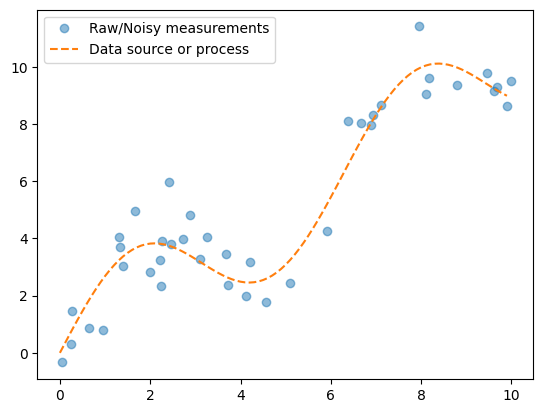

In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt


def wavyline(x, k=2):
    return k*torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n)*10)
y_train = wavyline(x_train) + torch.randn(n)

x_gt = torch.arange(0,10,0.1)
y_gt = wavyline(x_gt)

plt.plot(x_train,y_train, 'o', alpha=0.5)
plt.plot(x_gt, y_gt, '--')
plt.legend(['Raw/Noisy measurements', 'Data source or process'])
plt.show()


As you can see, we have generated 40 noisy datapoints for this curve.  

## Now, let's run the regression on our training data
Using our Gaussian kernel function, we can estimate the curve from the data with a weighted average of the kernel at different points.

$$
\hat{y} = \sum_i y_i* \frac{\phi(||x-x_i||)}{\sum_j \phi(||x-x_j||)}
$$

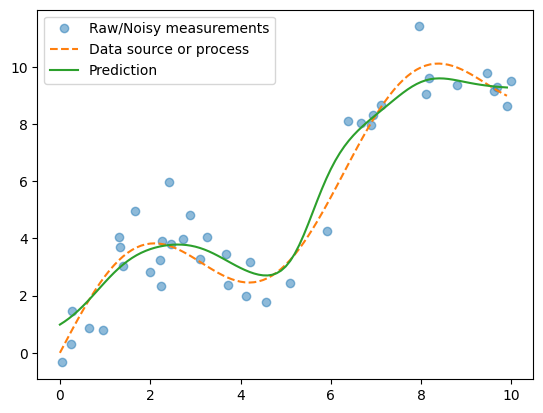

In [2]:
def gaussian(x, h=1):
    return torch.exp(-x**2/(2*h))


def nadaraya_watson_regression(x_train, y_train, x_gt, h=1.0):

    distances = x_train.reshape(-1,1) - x_gt.reshape(1,-1)
    weights = gaussian(distances, h)
    norm_weights = weights / weights.sum(0)
    y_pred = y_train@norm_weights
    return y_pred, norm_weights

y_pred, attn_weights = nadaraya_watson_regression(x_train, y_train, x_gt, 0.5)

plt.plot(x_train,y_train, 'o', alpha=0.5)
plt.plot(x_gt, y_gt, '--')
plt.plot(x_gt, y_pred)
plt.legend(['Raw/Noisy measurements', 'Data source or process', 'Prediction'])
plt.show()


The green curve is a fairly good approximation of the original source or process curve, without learning any parameters! 

We can experiment with different values of smoothing constant $ h $.

In [3]:
y_pred_0_1, weights_0_1 = nadaraya_watson_regression(x_train, y_train, x_gt, h=0.1)
y_pred_0_5, weights_0_5 = nadaraya_watson_regression(x_train, y_train, x_gt, h=0.5)
y_pred_1_0, weights_1_0 = nadaraya_watson_regression(x_train, y_train, x_gt, h=1.0)
y_pred_1_5, weights_1_5 = nadaraya_watson_regression(x_train, y_train, x_gt, h=1.5)

In [4]:
from manim import *
config.media_width ="100%"
config.verbosity = "ERROR"
config.progress_bar = "none"

In [5]:
%%manim -qm RegressionScene

class RegressionScene(Scene):
    def construct(self):

        ax = Axes(x_range=[0,10,1], y_range=[0,10,1], axis_config={"include_numbers": True})

        f1 = ax.plot_line_graph(x_gt, y_pred_0_1, add_vertex_dots=False)
        f2 = ax.plot_line_graph(x_gt, y_pred_0_5, add_vertex_dots=False)
        f3 = ax.plot_line_graph(x_gt, y_pred_1_0, add_vertex_dots=False)
        f4 = ax.plot_line_graph(x_gt, y_pred_1_5, add_vertex_dots=False)

        self.add(ax)
        for x,y in zip(x_train, y_train):
            dot = Dot(ax.c2p(x,y))
            self.add(dot)
        

        self.play(Transform(f1, f2))
        self.remove(f1)
        self.add(f2)
        self.play(Transform(f2, f3))
        self.remove(f2)
        self.add(f3)
        self.play(Transform(f3, f4))

        self.wait()





Manim Community v0.18.1

## Finally, we can interpret the regression weights as attention over the training data points
On the X axis, you can see the each of the input data points. On the Y axis, you can observe the attention weights over the training data

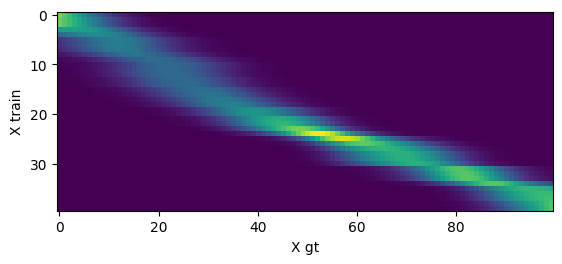

In [70]:
plt.imshow(attn_weights)
plt.xlabel("X gt")
plt.ylabel("X train")
plt.show()

In [7]:
im1_data = np.uint8((weights_0_1*255).numpy())
im2_data = np.uint8((weights_0_5*255).numpy())
im3_data = np.uint8((weights_1_0*255).numpy())
im4_data = np.uint8((weights_1_5*255).numpy())

In [68]:
config.media_width ="100%"
config.verbosity = "ERROR"
config.progress_bar = "none"

In [72]:
%%manim -qm AttentionScene

class AttentionScene(Scene):
    def construct(self):

        im1 = ImageMobject(im1_data)
        im1.height = 10 
        im1.add(Text("h=0.1"))
        im2 = ImageMobject(im2_data)
        im2.height = 10
        im2.add(Text("h=0.5"))
        im3 = ImageMobject(im3_data)
        im3.height = 10
        im3.add(Text("h=1.0"))
        im4 = ImageMobject(im4_data)
        im4.height = 10
        im4.add(Text("h=1.5"))

        self.add(im1)
        self.wait()
        self.remove(im1)
        self.add(im2)
        self.wait()
        self.remove(im2)
        self.add(im3)
        self.wait()
        self.remove(im3)
        self.add(im4)
        self.wait()
        self.remove(im4)


Manim Community v0.18.1

Notice how the attention weights become more diffuse as the $ h $ value increases from 0.1 to 1.5 .